In [1]:
import json
from pathlib import Path
import pandas as pd 
import tensorflow as tf 
import numpy as np
from tensorflow.data import Dataset 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model
import cv2
import matplotlib.pyplot as plt 

2024-12-28 17:17:31.582828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735406251.622473   30320 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735406251.635536   30320 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 17:17:31.699666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Setup and Dataset

In [2]:
with open("../config.json") as file:
    config = json.load(file)
 
aptos2019_path = Path(config["dataset"]["aptos_2019"]["balanced_resized"])
models_trained_path = Path(config["models_trained"])

In [3]:
csv = pd.read_csv(aptos2019_path / "labels.csv")
images_path = str(aptos2019_path / "images")

num_class = 5
def name2image_class2onehot(tensor):
    # Loading and processing image
    image_name = "/" + tensor["img_name"] + ".png"
    image_path = images_path + image_name
    image_file = tf.io.read_file(image_path)
    image_file = tf.io.decode_png(image_file,channels=3)
    image_file = tf.cast(image_file,tf.float32)
    image_file = tf.image.resize(image_file,[224,224])
    image_file /= 255.0
    # onehotting the class 
    onehot_class = tf.one_hot(tensor["class"], depth = num_class)
    
    return (image_file, onehot_class)

tf.random.set_seed(342)
aptos2019_dataset = (Dataset
                     .from_tensor_slices(dict(csv))
                     .shuffle(len(csv))
                     .map(name2image_class2onehot))

# Selecting sizes of train, val and test dataset
dataset_size = dict() 
dataset_size["train"] = 0.7 
dataset_size["val"]   = 0.2
dataset_size["test"]  = 0.1

# creating train, test, val datasets
for key in dataset_size:
    dataset_size[key] = int(dataset_size[key] * len(aptos2019_dataset))
dataset = dict()
dataset["train"] = aptos2019_dataset.take(dataset_size["train"]) 
dataset["val"] = aptos2019_dataset.skip(dataset_size["train"]).take(dataset_size["val"])
dataset["test"] = aptos2019_dataset.skip(dataset_size["train"] + dataset_size["val"]).take(dataset_size["test"]) 

# batching the splits
batch_size = 8
dataset["train"] = dataset["train"].batch(batch_size)
dataset["val"] = dataset["val"].batch(batch_size)
#  dataset["test"] = dataset["test"].batch(batch_size)

print("Splitting sizes:")
for key in dataset_size:
    print(f"- {key} size : {dataset_size[key]}")

# example of a tensor from train set
print("\nExample Tensor:")
for tensor in dataset["train"].take(1):
    print("Batched Input shape:", tensor[0].shape)
    print("Batched One-hot Tensor Shape:", tensor[1].shape)
    print("One-hot Tensor numpy", tensor[1].numpy()[0])

I0000 00:00:1735406263.563218   30320 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Splitting sizes:
- train size : 12959
- val size : 3702
- test size : 1851

Example Tensor:
Batched Input shape: (8, 224, 224, 3)
Batched One-hot Tensor Shape: (8, 5)
One-hot Tensor numpy [0. 0. 0. 0. 1.]


2024-12-28 17:17:44.674685: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
def grad_cam(input, output, model, last_conv_layer_name):
    
    # returns outputs from last conv layer and last layer
    def grad_mod(input):
        activations = None 
        x = input
        for layer in model.layers:
            x = layer(x)
            if layer.name == last_conv_layer_name:
                activations = x 
        return activations, x

    # Wrap for watching with tape
    x = tf.Variable(input) 

    # Forward pass 
    with tf.GradientTape() as tape:
        activations, predictions = grad_mod(x) 
        class_channel = predictions[:,output] 

    # How much the activation affects the class channel
    grads = tape.gradient(class_channel, activations)

    # Average of all the kernel gradients
    activation_weights = tf.reduce_mean(grads, axis=(0, 1, 2)) 
    # Alternative
    # activation_weights = np.sum(grads, axis=(0,1,2)) / 196 #  1 * 14 * 14

    activations = activations[0]

    # Add all activation maps with computed weights
    heatmap = np.dot(activations, activation_weights) 
    # Alternative
    # heatmap = activations @ pooled_grads[..., tf.newaxis]
    # heatmap = tf.squeeze(heatmap)

    # ReLU to remove negative activations
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    return heatmap

In [13]:
def overlay_heatmap(image, heatmap):
    alpha = 1
    beta = 0.001
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    image_to_plot = heatmap
    image_to_plot = cv2.resize(image_to_plot, image.shape[0:-1], interpolation = cv2.INTER_LINEAR)
    image_to_plot = cv2.normalize(image_to_plot, None, 0, 255, cv2.NORM_MINMAX) 
    image_to_plot = cv2.applyColorMap(image_to_plot.astype(np.uint8),cv2.COLORMAP_JET)
    image_to_plot = cv2.addWeighted(image, alpha, image_to_plot.astype(np.float32), beta, 0)
    image_to_plot = cv2.normalize(image_to_plot,None, 0, 1, cv2.NORM_MINMAX)
    image_to_plot = cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB)
    
    return image_to_plot

#### CNN-1

In [16]:
model_cnn_1 = load_model(models_trained_path / "cnn_1.keras")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.015202e-11..1.0].


CLASS : 3
PRED :  13


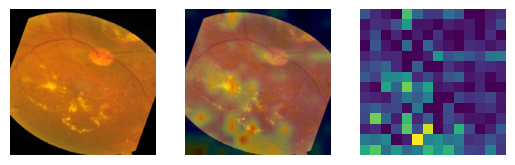

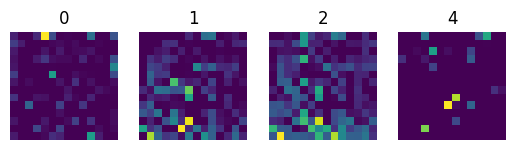

CLASS : 3
PRED :  3


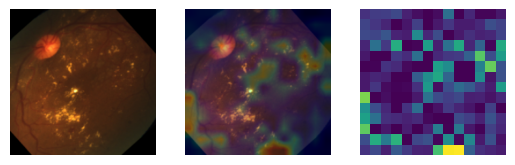

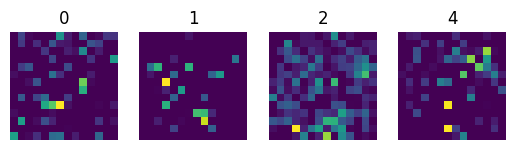

CLASS : 4
PRED :  32


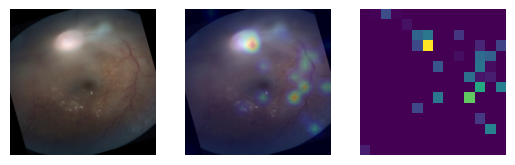

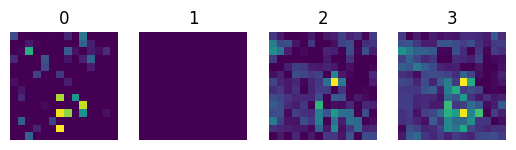

CLASS : 1
PRED :  23


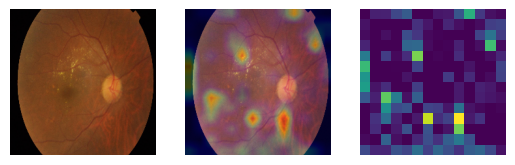

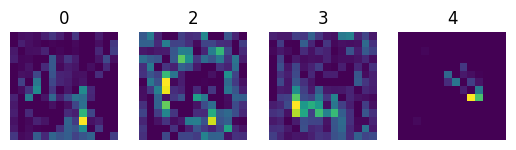

CLASS : 0
PRED :  20


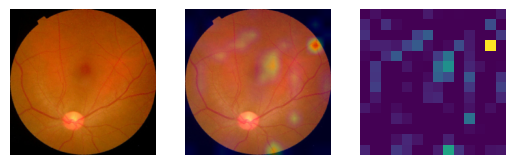

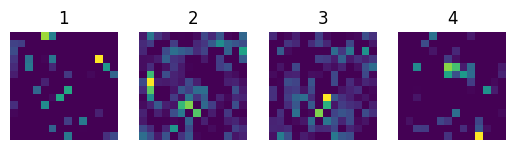

CLASS : 0
PRED :  0


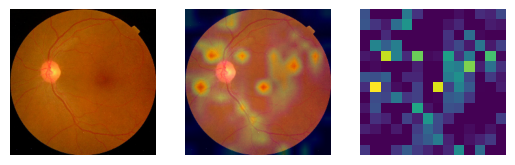

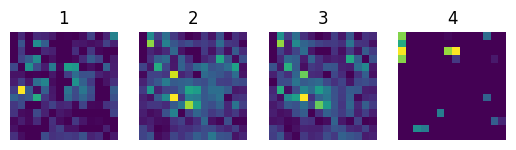

CLASS : 4
PRED :  35


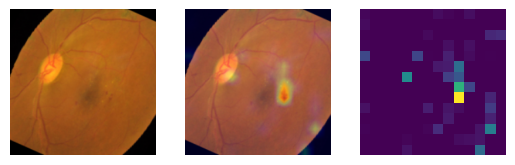

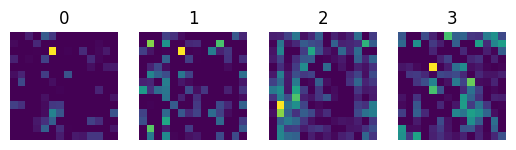

CLASS : 1
PRED :  36


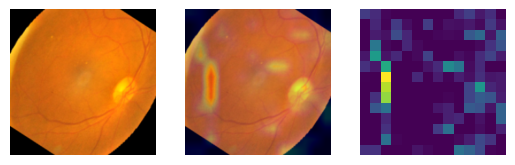

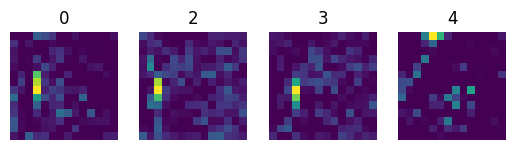

CLASS : 4
PRED :  18


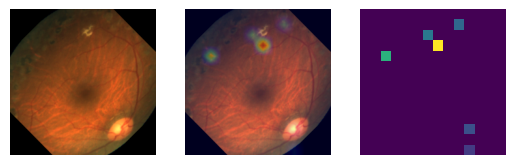

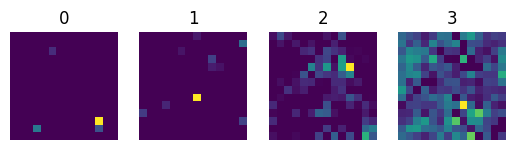

CLASS : 0
PRED :  5


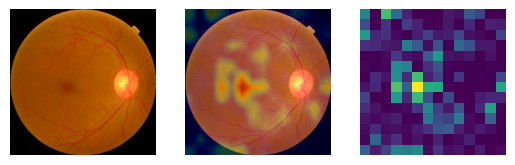

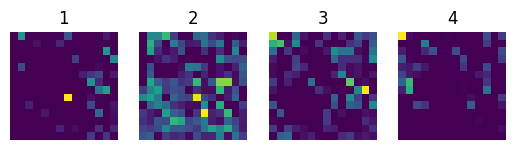

In [17]:
generate_grad_cam_plots(model_cnn_1, "conv2d_4", dataset["train"])